<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
<center>

## Специализация "Машинное обучение и анализ данных"

## Идентификация интернет-пользователей

### Цели и задачи проекта, описание исходных и обработанных данных и признаков

В этом проекте рассматривается **задача идентификации пользователя** по его поведению в сети Интернет, а именно - по последовательности из нескольких веб-сайтов, посещенных подряд одним и тем же человеком. Идея такая: пользователи Интернета по-разному переходят по ссылкам, и это может помогать их идентифицировать.

Таким образом, решается задача множественной классификации.

**Исходные данные** состоят из перечня сайтов и времени посещения этих сайтов каждым пользователем. На соревновании в [kaggle](https://www.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/leaderboard
) данные уже разделены по сессиям, которые не могут быть длинее получаса или 10 сайтов.

Для сайтов, имеющихся в исходных данных, составили частотный словарь сайтов вида {'site_string': [site_id, site_freq]}.  

Исходные данные разделили на сессии для обучения классификатора выборках с различными значениями параментрами длины сессии и длины скользящего окна. Значениям параметра длины сессии могут принимать - 15, 10, 7 или 5,  и значениям параметра длины скользящего окна -  10, 7 или 5. Получили 9 различных вариантов выборки. 

Для каждой выборки воспользовались идеей мешка слов. Создали новые матрицы, в которых строкам будут соответствовать сессии, а столбцам – индексы сайтов. На пересечении строки  𝑖  и столбца  𝑗  стоит число  𝑛𝑖𝑗  – cколько раз сайт  𝑗  встретился в сессии номер  𝑖 . Реализовали это с помощью разреженных матриц Scipy – csr_matrix. 



###  Первичный анализ признаков и первичный визуальный анализ признаков

В задании было предложено создать следующе признаки:

- `time_diff1` – время, проведённое на первом сайте
- `time_diff2` – время, проведённое на втором сайте
- `time_diff3` – время, проведённое на третьем сайте
- `time_diff4` – время, проведённое на четвёртом сайте
- `time_diff5` – время, проведённое на пятом сайте
- `time_diff6` – время, проведённое на шестом сайте
- `time_diff7` – время, проведённое на седьмом сайте
- `time_diff8` – время, проведённое на восьмом сайте
- `time_diff9` – время, проведённое на девятом сайте
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `start_day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Дополнительно добавили следующие признаки:
- `start_day` – день начала сессии (то есть час в записи минимального timestamp среди десяти)
- `start_month` – месяц начала сессии (то есть час в записи минимального timestamp среди десяти)
- `start_year` – год начала сессии (то есть час в записи минимального timestamp среди десяти)
- `time_of_day'` – время суток начала сессии
    * 00:00 - 06:00: ночь
    * 06:00 - 12:00: утро
    * 12:00 - 18:00: день
    * 18:00 - 0:00: вечер
        
- `visit_10_top` – индикатор посещения хотя бы 1 из 10 популярных сайтов
    * 1 - посетили хотя бы 1 из 10 популярных сайтов
    * 0 - иначе
- `mean_time` – среднее время, проведённое на каждом сайте в сессии



Для примера визуализации загрузим DataFrame с вышеперечисленными признаками и частотный словарь для 10 пользователей.

In [2]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
#pip install seaborn
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt

from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score

In [3]:
PATH_TO_DATA = "C:/Users/Admin/Course/6"

In [4]:
with open(os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'), 'rb') as site_freq_10users_pkl:
        dict_site_10 = pickle.load(site_freq_10users_pkl)

In [5]:
with open(os.path.join(PATH_TO_DATA, 'new_features_10users_1.pkl'), 'rb') as new_features_10users_pkl:
        new_features_10users = pickle.load(new_features_10users_pkl)

In [6]:
new_features_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,...,time_diff9,session_timespan,#unique_sites,start_hour,start_day,start_month,start_year,start_day_of_week,time_of_day,visit_10_top,mean_time,target
0,1.0,2.0,3.0,4.0,3.0,3.0,4.0,3.0,5.0,3.0,10.0,0.0,...,0.0,33.0,5.0,8.0,15.0,11.0,2013.0,5.0,1.0,1.0,3.666667,31.0
1,6.0,7.0,8.0,9.0,3.0,10.0,11.0,12.0,13.0,14.0,1.0,0.0,...,8.0,284.0,10.0,8.0,15.0,11.0,2013.0,5.0,1.0,0.0,31.555556,31.0
2,14.0,4.0,14.0,14.0,15.0,16.0,6.0,17.0,18.0,14.0,0.0,14.0,...,0.0,258.0,7.0,8.0,15.0,11.0,2013.0,5.0,1.0,1.0,28.666667,31.0
3,19.0,20.0,19.0,14.0,14.0,14.0,14.0,21.0,22.0,23.0,2.0,1.0,...,0.0,30.0,6.0,8.0,15.0,11.0,2013.0,5.0,1.0,0.0,3.333333,31.0
4,24.0,14.0,15.0,25.0,26.0,27.0,28.0,29.0,30.0,29.0,1.0,0.0,...,0.0,6.0,9.0,8.0,15.0,11.0,2013.0,5.0,1.0,1.0,0.666667,31.0


**Распределение целевого класса:**

In [7]:
new_features_10users['target'].value_counts()

128.0    2796
39.0     2204
207.0    1868
127.0    1712
237.0    1643
33.0     1022
50.0      802
31.0      760
100.0     720
241.0     534
Name: target, dtype: int64

***Выборка - не сбалансирована.***

Построим гистограммы распределения для всех признаков.

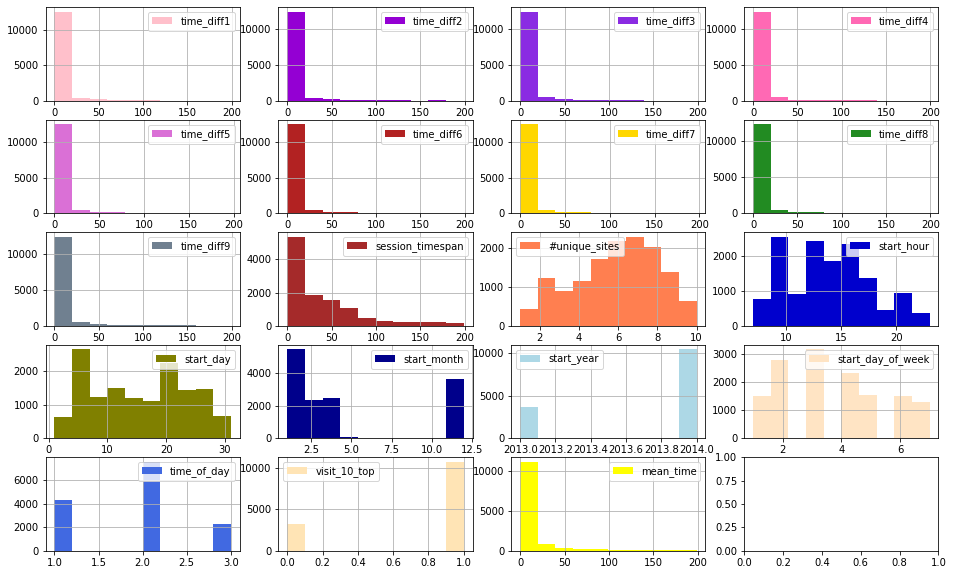

In [8]:
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(16, 10))
colors = ['pink',  'darkviolet', 'blueviolet','hotpink', 'orchid', 'firebrick', 'gold',  'forestgreen', 
        'slategrey', 'brown', 'coral', 'mediumblue', 'olive', 'darkblue', 'lightblue', 
         'bisque', 'royalblue', 'moccasin', 'yellow', 'blue']
# как вариант, можно и по-другому
for i in range(len(new_features_10users.columns)-11):
    ind = i+10
    if new_features_10users.columns[ind] !='start_year':
        axes[i//4, i%4].hist(new_features_10users[new_features_10users[new_features_10users.columns[ind]]<200][new_features_10users.columns[ind]].values,color = colors[i], label = new_features_10users.columns[ind])
    #axes[i//4, i%4].set(xlabel=new_features_10users.columns[ind], ylabel = 'количество повторов' )
    else:
        axes[i//4, i%4].hist(new_features_10users[new_features_10users.columns[ind]].values,color = colors[i], label = new_features_10users.columns[ind])
    axes[i//4, i%4].grid()
    axes[i//4, i%4].legend()


Самыми инетерсными признаками оказались - '#unique_sites', 'start_hour', 'start_day', 'start_day_of_week' и 'time_of_day'.

Построим гистограммы распределения для каждого из 10 пользователей по отдельности для этих признаков.

In [9]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}

new_features_10users['target'] = new_features_10users['target'].map(id_name_dict)

color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

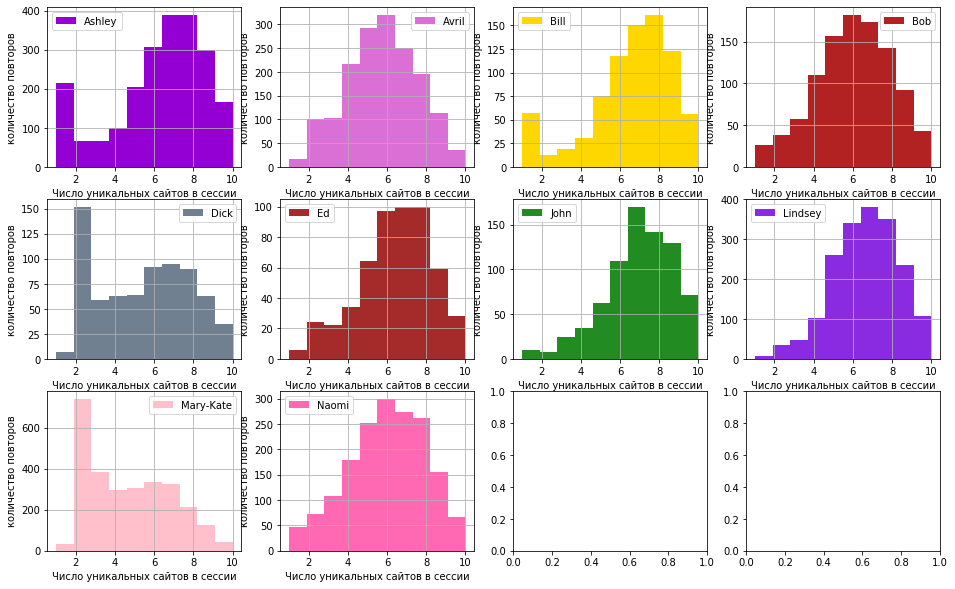

In [10]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(new_features_10users.groupby(['target'])): 
    axes[idx//4, idx%4].hist(sub_df['#unique_sites'].values, color = color_dic[user], label = user)
    axes[idx//4, idx%4].set(xlabel='Число уникальных сайтов в сессии', ylabel = 'количество повторов' )
    axes[idx//4, idx%4].grid()
    axes[idx//4, idx%4].legend()

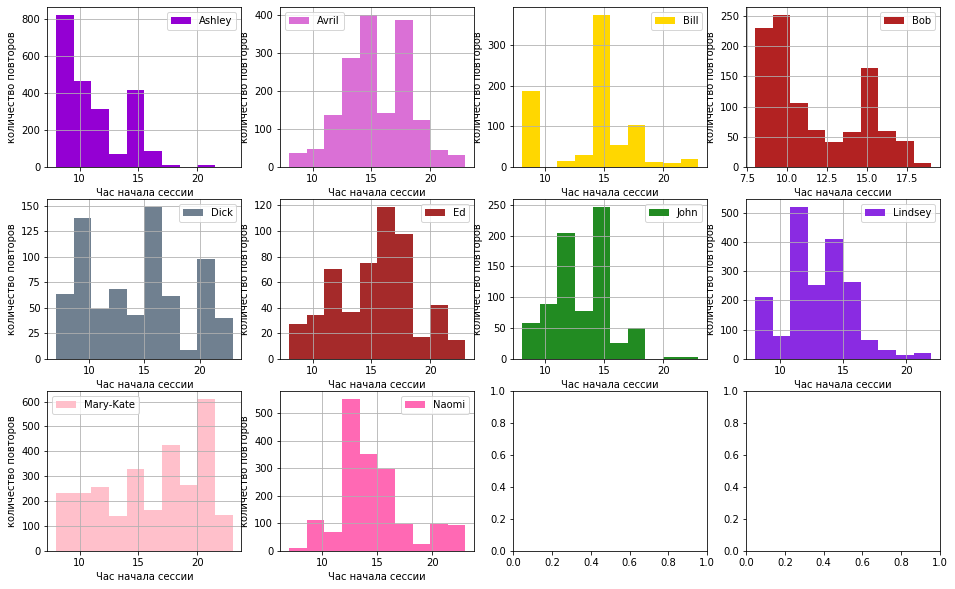

In [11]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(new_features_10users.groupby(['target'])): 
    axes[idx//4, idx%4].hist(sub_df['start_hour'].values, color = color_dic[user], label = user)
    axes[idx//4, idx%4].set(xlabel='Час начала сессии', ylabel = 'количество повторов' )
    axes[idx//4, idx%4].grid()
    axes[idx//4, idx%4].legend()

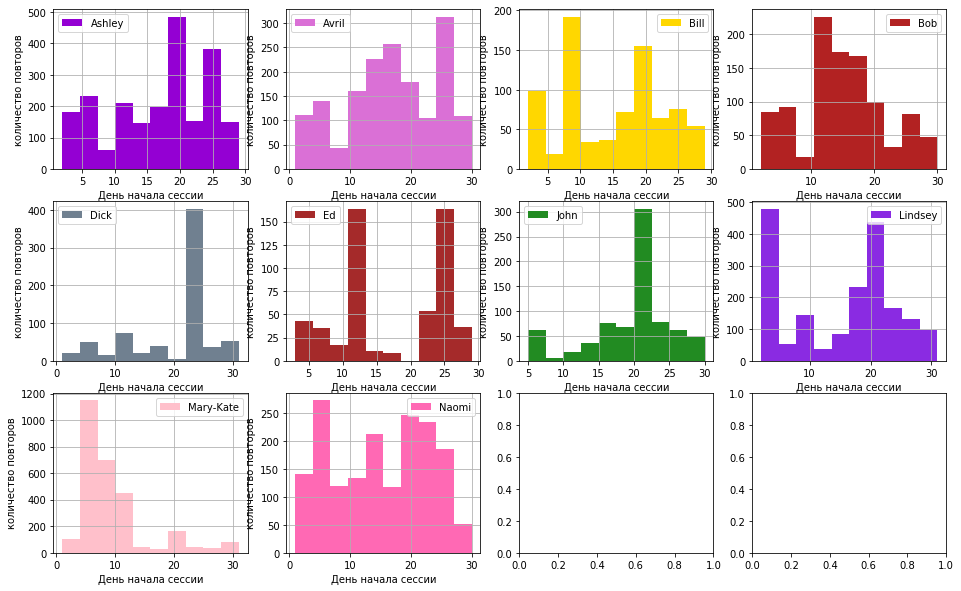

In [12]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(new_features_10users.groupby(['target'])): 
    axes[idx//4, idx%4].hist(sub_df['start_day'].values, color = color_dic[user], label = user)
    axes[idx//4, idx%4].set(xlabel='День начала сессии', ylabel = 'количество повторов' )
    axes[idx//4, idx%4].grid()
    axes[idx//4, idx%4].legend()

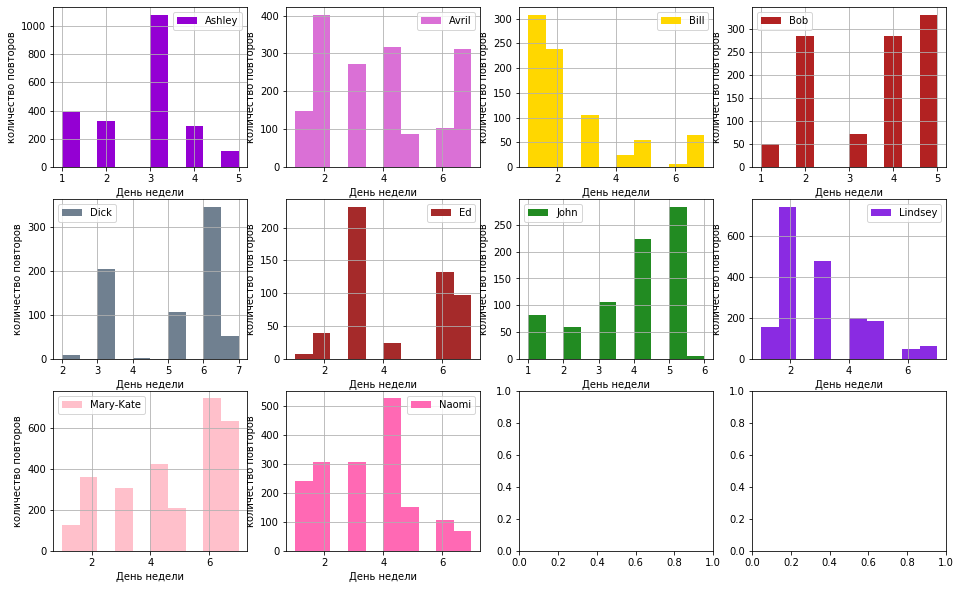

In [13]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(new_features_10users.groupby(['target'])): 
    axes[idx//4, idx%4].hist(sub_df['start_day_of_week'].values, color = color_dic[user], label = user)
    axes[idx//4, idx%4].set(xlabel='День недели', ylabel = 'количество повторов' )
    axes[idx//4, idx%4].grid()
    axes[idx//4, idx%4].legend()

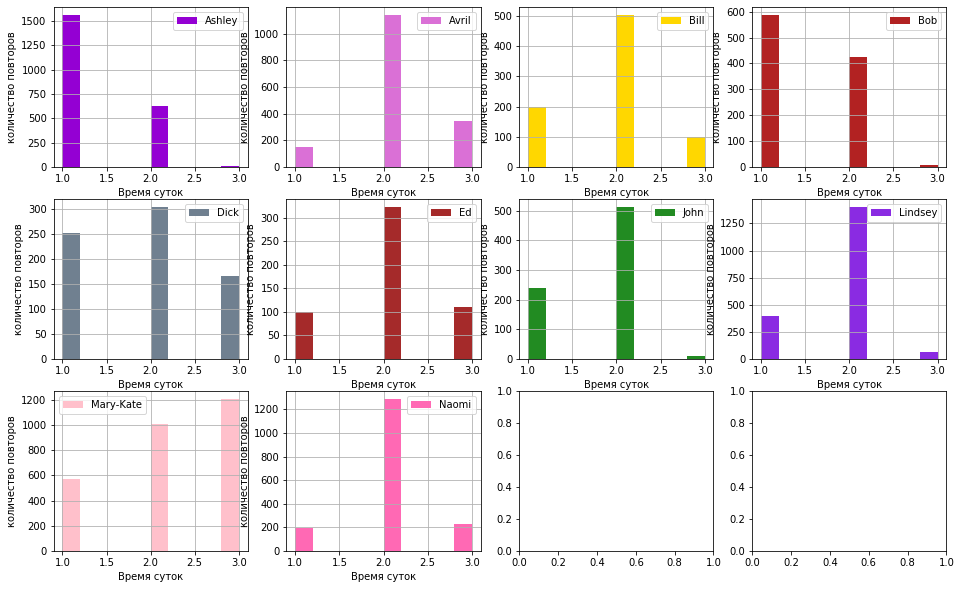

In [14]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(new_features_10users.groupby(['target'])): 
    axes[idx//4, idx%4].hist(sub_df['time_of_day'].values, color = color_dic[user], label = user)
    axes[idx//4, idx%4].set(xlabel='Время суток', ylabel = 'количество повторов' )
    axes[idx//4, idx%4].grid()
    axes[idx//4, idx%4].legend()

In [15]:
def mechok(docs):
    indptr = [0]
    indices = []
    data = []
    vocabulary = {}
    for d in docs:
        for term in d:
            if float(term)==0:
                continue
            index = vocabulary.setdefault(term, len(vocabulary))
            indices.append(index)
            data.append(1)     
        indptr.append(len(indices))
    return (csr_matrix((data, indices, indptr), dtype=int))

In [16]:
new_features_10users_sparse = mechok(new_features_10users.iloc[:,:-1].values) 

###  Оценка модели с описанием выбранной метрики. Кросс-валидация, построение кривых валидации и обучения

Разделили выборку на обучающую и валидационную.

In [17]:
X = new_features_10users_sparse
y = new_features_10users.iloc[:,-1]

In [18]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=17, stratify=y)

Задали 3-кратную кросс-валидацию

In [19]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

С помощью LogisticRegressionCV подобрали параметр C для LogisticRegression.

In [20]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [21]:
%%time
logit_c_values2 = np.linspace(0.1, 1, 20)

logit_grid_searcher2 = LogisticRegressionCV(logit_c_values2, multi_class='multinomial', random_state=17)#### ''' ВАШ КОД ЗДЕСЬ ''' 
logit_grid_searcher2.fit(X_train, y_train)

Wall time: 5min 45s


LogisticRegressionCV(Cs=array([0.1       , 0.14736842, 0.19473684, 0.24210526, 0.28947368,
       0.33684211, 0.38421053, 0.43157895, 0.47894737, 0.52631579,
       0.57368421, 0.62105263, 0.66842105, 0.71578947, 0.76315789,
       0.81052632, 0.85789474, 0.90526316, 0.95263158, 1.        ]),
                     class_weight=None, cv='warn', dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='multinomial', n_jobs=None,
                     penalty='l2', random_state=17, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

In [22]:
logit_scores_2 = logit_grid_searcher2.scores_.items()
logit_scores_2 = list(logit_scores_2)
X_logit_scores_2 = []

for i in range(len(logit_scores_2)):
    for k in range(3):
        X_logit_scores_2.append(list(logit_scores_2[i][1][k]))
X_logit_scores_2 = np.array(X_logit_scores_2)

In [23]:
logit_mean_cv_scores2 = np.mean( X_logit_scores_2, axis = 0)

In [24]:
logit_mean_cv_scores2

array([0.78348132, 0.79039007, 0.79323455, 0.79496006, 0.79638298,
       0.79607733, 0.79648352, 0.79668742, 0.79678892, 0.79628123,
       0.79658765, 0.79689256, 0.79668906, 0.79689207, 0.79648528,
       0.79648488, 0.79617991, 0.79628135, 0.79648436, 0.79628163])

In [25]:
print('The best С =', logit_c_values2[np.argmax(logit_mean_cv_scores2)])

The best С = 0.6210526315789474


Кривая валидации по параметру С

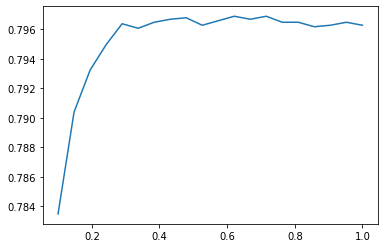

In [26]:
plt.plot(logit_c_values2, logit_mean_cv_scores2);

Доля правильных ответов на кросс-валидации для логистической регрессии (LogisticRegression) с лучшим параметром C

In [27]:
logit_c = LogisticRegression(random_state=17, C= logit_c_values2[np.argmax(logit_mean_cv_scores2)])

In [28]:
results_logit = cross_val_score(logit_c, X_train, y_train, cv=skf) 

In [29]:
print("cross_val_score = ", results_logit)
print('mean of cross_val_score = ', results_logit.mean())

cross_val_score =  [0.80913242 0.80878317 0.79987797]
mean of cross_val_score =  0.8059311866884037


Обучили логистическую регрессию (LogisticRegression) с лучшим параметром C и нашли её точность.

In [30]:
logit_c.fit(X_train, y_train)

LogisticRegression(C=0.6210526315789474, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=17, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [31]:
logit_c_cv_acc = accuracy_score(y_valid, logit_c.predict(X_valid))

In [32]:
print("точность равна ", logit_c_cv_acc )

точность равна  0.8170182507703247


С помощью GridSearchCV подобрали параметр C для SVM

In [33]:
from sklearn.svm import LinearSVC

In [34]:
svm = LinearSVC(random_state=17, C= 1)

In [35]:
%%time
svm_params2 = {'C': np.linspace(1e-3, 0.15, 30)}

svm_grid_searcher2 = GridSearchCV(svm, svm_params2)  ####''' ВАШ КОД ЗДЕСЬ '''
svm_grid_searcher2.fit(X_train, y_train)

Wall time: 7min 55s


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LinearSVC(C=1, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=17, tol=0.0001, verbose=0),
             iid='warn', n_jobs=None,
             param_grid={'C': array([0.001     , 0.00613793, 0.01127586, 0.01641379, 0.02155172,
       0.02668966, 0.03182759, 0.03696552, 0.04210345, 0.04724138,
       0.05237931, 0.05751724, 0.06265517, 0.0677931 , 0.07293103,
       0.07806897, 0.0832069 , 0.08834483, 0.09348276, 0.09862069,
       0.10375862, 0.10889655, 0.11403448, 0.11917241, 0.12431034,
       0.12944828, 0.13458621, 0.13972414, 0.14486207, 0.15      ])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [36]:
svm_grid_searcher2.best_estimator_

LinearSVC(C=0.0626551724137931, class_weight=None, dual=True,
          fit_intercept=True, intercept_scaling=1, loss='squared_hinge',
          max_iter=1000, multi_class='ovr', penalty='l2', random_state=17,
          tol=0.0001, verbose=0)

In [37]:
print("The best C =", svm_grid_searcher2.best_params_['C'] )

The best C = 0.0626551724137931


Кривая валидации по параметру С

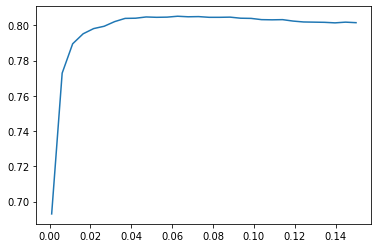

In [38]:
plt.plot(svm_params2['C'],svm_grid_searcher2.cv_results_['mean_test_score'])

Доля правильных ответов на кросс-валидации для логистической регрессии (LogisticRegression) с лучшим параметром C

In [40]:
svm_2 = LinearSVC(random_state=17, C= svm_grid_searcher2.best_params_['C'])

In [41]:
results_svm = cross_val_score(svm_2, X_train, y_train, cv=skf) 

In [42]:
print("cross_val_score = ", results_svm)
print('mean of cross_val_score = ', results_svm.mean())

cross_val_score =  [0.81339422 0.81183288 0.80506406]
mean of cross_val_score =  0.8100970518213529


Обучили LinearSVC с лучшим параметром C и нашли её точность.

In [43]:
svm_2.fit(X_train, y_train)
pred_svm_2 = svm_2.predict(X_valid)

In [44]:
svm_cv_acc =  accuracy_score(y_valid, pred_svm_2 ) 

In [45]:
svm_cv_acc

0.8219957335861579

Создали объект sklearn.linear_model.SGDClassifier с логистической функцией потерь и обучили модель.

In [46]:
from sklearn.linear_model import SGDClassifier

In [47]:
sgd_logit = SGDClassifier(loss='log', n_jobs=-1, random_state=17)       
sgd_logit.fit(X_train, y_train) 

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=-1, penalty='l2', power_t=0.5,
              random_state=17, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [48]:
sgd_logit_valid_pred = sgd_logit.predict(X_valid)

In [49]:
sgd_logit_acc =  accuracy_score(y_valid, sgd_logit_valid_pred ) 

In [50]:
sgd_logit_acc

0.8061151931737378

In [51]:
train_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_sessions.csv'),
                       index_col='session_id')
test_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_sessions.csv'),
                      index_col='session_id')

In [52]:
train_df

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,2014-02-22 11:19:51,3846.0,2014-02-22 11:19:51,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16,0
3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,2013-12-16 16:40:19,39.0,2013-12-16 16:40:19,14768.0,2013-12-16 16:40:20,14768.0,2013-12-16 16:40:21,14768.0,2013-12-16 16:40:22,14768.0,2013-12-16 16:40:24,0
4,782,2014-03-28 10:52:12,782.0,2014-03-28 10:52:42,782.0,2014-03-28 10:53:12,782.0,2014-03-28 10:53:42,782.0,2014-03-28 10:54:12,782.0,2014-03-28 10:54:42,782.0,2014-03-28 10:55:12,782.0,2014-03-28 10:55:42,782.0,2014-03-28 10:56:12,782.0,2014-03-28 10:56:42,0
5,22,2014-02-28 10:53:05,177.0,2014-02-28 10:55:22,175.0,2014-02-28 10:55:22,178.0,2014-02-28 10:55:23,177.0,2014-02-28 10:55:23,178.0,2014-02-28 10:55:59,175.0,2014-02-28 10:55:59,177.0,2014-02-28 10:55:59,177.0,2014-02-28 10:57:06,178.0,2014-02-28 10:57:11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253557,3474,2013-11-25 10:26:54,3474.0,2013-11-25 10:26:58,141.0,2013-11-25 10:27:03,2428.0,2013-11-25 10:27:04,106.0,2013-11-25 10:27:13,2428.0,2013-11-25 10:27:16,2428.0,2013-11-25 10:27:28,2428.0,2013-11-25 10:27:40,2428.0,2013-11-25 10:27:52,148.0,2013-11-25 10:27:53,0
253558,12727,2013-03-12 16:01:15,12727.0,2013-03-12 16:01:16,2215.0,2013-03-12 16:01:16,38.0,2013-03-12 16:01:17,2215.0,2013-03-12 16:01:17,23.0,2013-03-12 16:01:17,25444.0,2013-03-12 16:01:18,2215.0,2013-03-12 16:01:18,23.0,2013-03-12 16:01:18,21.0,2013-03-12 16:01:18,0
253559,2661,2013-09-12 14:05:03,15004.0,2013-09-12 14:05:10,5562.0,2013-09-12 14:05:10,5562.0,2013-09-12 14:06:29,5562.0,2013-09-12 14:06:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [53]:
train_df.fillna(0).iloc[0,:].nunique()

3

In [54]:
train_test_df = pd.concat([train_df, test_df])

In [55]:
train_test_df_sites = train_test_df[['site%d' % i for i in range(1, 11)]].fillna(0).astype('int')

In [56]:
train_test_df_sites

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
1,718,0,0,0,0,0,0,0,0,0
2,890,941,3847,941,942,3846,3847,3846,1516,1518
3,14769,39,14768,14769,37,39,14768,14768,14768,14768
4,782,782,782,782,782,782,782,782,782,782
5,22,177,175,178,177,178,175,177,177,178
...,...,...,...,...,...,...,...,...,...,...
82793,812,1039,676,0,0,0,0,0,0,0
82794,300,302,302,300,300,1222,302,1218,1221,1216
82795,29,33,35,22,37,6779,30,21,23,6780


In [57]:
def time_day(x):
    if (x>=0 and x<6):
        return 0
    elif (6>=0 and x<12):
        return 1
    elif (12>=0 and x<18):
        return 2
    else:
        return 3

In [58]:
def maxi(a):
    if len(a)==0:
        return 0
    else:
        return(np.mean(a))

In [59]:
def weekend(a):

    if (a==6 or a==7):
        b=1
    else:
            b=0
    return(b)

In [156]:
def feature_engineering(data, features):
    
    X=np.zeros((data.shape[0], len(features)))
    unique_sites = np.zeros(data.shape[0])
    data = data.fillna(0)
    uni_site= list(map(lambda x: np.unique(x),(data[['site%d' % i for i in range(1, 11)]].values) ))
    b = list(map(lambda x: 0 in x,uni_site ))
    count_uni_site=list(map(lambda x,y: len(x) - y,uni_site,b))
    
    dateFormatter = "%Y-%m-%d  %H:%M:%S"

    X[:,:10] = data[['site%d' % i for i in range(1, 11)]].values
    
    Y=np.zeros((train_test_df.shape[0],9))
    time= train_test_df[['time%d' % i for i in range(1, 11)]].values
    c = list(map(lambda x: 10 - list(x).count(0),(train_test_df[['time%d' % i for i in range(1, 11)]].fillna(0).values) ))
    time_1 = []
    for i in range(train_test_df.shape[0]):
        a = list(map(lambda x: datetime.strptime(x, dateFormatter), list(time[i,:c[i]])))
        time_1.append(a[0])
        q=(list(map(lambda x,y: (y-x).seconds, a[:-1],a[1:])))
        Y[i,:len(q)] = q 

    
    X[:,10:19] = Y
        
    X[:, len(features)-10] = np.sum(X[:,10:19], axis = 1)

    X[:, len(features)-9] = count_uni_site

    X[:, len(features)-8] =  list(map(lambda x: x.hour, time_1))

    X[:, len(features)-7] =  list(map(lambda x: x.day, time_1))

    X[:, len(features)-6] =  list(map(lambda x: x.month, time_1))

    X[:, len(features)-5] =  list(map(lambda x: x.year, time_1))


    X[:, len(features)-4] = list(map(lambda x: x.isoweekday() , time_1))
    ## от 1 до 7
    
    X[:, len(features)-2] = np.mean(X[:,10:19], axis=1)

    X[:, len(features)-3] = list(map(lambda x: time_day(x), X[:, len(features)-8]))
    
    X[:, len(features)-1] =  list(map(lambda x: weekend(x), X[:, len(features)-4]))



    data=pd.DataFrame(X,columns=features)
    return(data)

In [157]:
from datetime import datetime
from tqdm import tqdm

In [158]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 'start_day', 'start_month', 'start_year',
                 'start_day_of_week', "time_of_day",'mean_time','weekends']

In [159]:
train_test_df_new = feature_engineering(train_test_df,feature_names)

In [160]:
train_test_df_new

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,...,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,start_day,start_month,start_year,start_day_of_week,time_of_day,mean_time,weekends
0,718.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,10.0,20.0,2.0,2014.0,4.0,1.0,0.000000,0.0
1,890.0,941.0,3847.0,941.0,942.0,3846.0,3847.0,3846.0,1516.0,1518.0,0.0,1.0,...,23.0,1.0,26.0,7.0,11.0,22.0,2.0,2014.0,6.0,1.0,2.888889,1.0
2,14769.0,39.0,14768.0,14769.0,37.0,39.0,14768.0,14768.0,14768.0,14768.0,1.0,1.0,...,1.0,2.0,7.0,4.0,16.0,16.0,12.0,2013.0,1.0,2.0,0.777778,0.0
3,782.0,782.0,782.0,782.0,782.0,782.0,782.0,782.0,782.0,782.0,30.0,30.0,...,30.0,30.0,270.0,1.0,10.0,28.0,3.0,2014.0,5.0,1.0,30.000000,0.0
4,22.0,177.0,175.0,178.0,177.0,178.0,175.0,177.0,177.0,178.0,137.0,0.0,...,67.0,5.0,246.0,4.0,10.0,28.0,2.0,2014.0,5.0,1.0,27.333333,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336353,812.0,1039.0,676.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,18.0,2.0,10.0,2014.0,4.0,3.0,0.000000,0.0
336354,300.0,302.0,302.0,300.0,300.0,1222.0,302.0,1218.0,1221.0,1216.0,1.0,3.0,...,0.0,0.0,39.0,6.0,14.0,26.0,5.0,2014.0,1.0,2.0,4.333333,0.0
336355,29.0,33.0,35.0,22.0,37.0,6779.0,30.0,21.0,23.0,6780.0,0.0,0.0,...,0.0,0.0,8.0,10.0,11.0,2.0,5.0,2014.0,5.0,1.0,0.888889,0.0
336356,5828.0,23.0,21.0,804.0,21.0,3350.0,23.0,894.0,21.0,961.0,2.0,0.0,...,0.0,0.0,13.0,7.0,10.0,3.0,5.0,2014.0,6.0,1.0,1.444444,1.0


In [161]:
train_test_data = pd.get_dummies(train_test_df_new, columns=['start_day_of_week', "time_of_day"])

In [269]:
train_test_sparse = mechok(train_test_data_1.values)   ####''' ВАШ КОД ЗДЕСЬ '''
X_train_sparse = train_test_sparse[:train_df.shape[0],:]      ####''' ВАШ КОД ЗДЕСЬ '''
X_test_sparse =  train_test_sparse[train_df.shape[0]: ,:]      ####''' ВАШ КОД ЗДЕСЬ '''
y = train_df.target.values      

In [270]:
train_share = int(.7 * X_train_sparse.shape[0])
X_train, y_train = X_train_sparse[:train_share, :], y[:train_share]
X_valid, y_valid  = X_train_sparse[train_share:, :], y[train_share:]

In [271]:
logit_c.fit(X_train, y_train)

LogisticRegression(C=0.6210526315789474, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=17, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [272]:
logit_c_cv_acc = accuracy_score(y_valid, logit_c.predict(X_valid))

In [273]:
logit_c_cv_acc

0.9931378090943749

In [274]:
from sklearn.metrics import roc_auc_score

In [275]:
round(roc_auc_score(y_valid, logit_c.predict_proba(X_valid)[:, 1]), 3)

0.975

In [276]:
svm_2.fit(X_train, y_train)
pred_svm_2 = svm_2.predict(X_valid)

In [277]:
svm_cv_acc =  accuracy_score(y_valid, pred_svm_2 ) 

In [278]:
svm_cv_acc

0.9928485979834099

In [279]:
sgd_logit.fit(X_train, y_train) 

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=-1, penalty='l2', power_t=0.5,
              random_state=17, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [280]:
sgd_logit_acc =  accuracy_score(y_valid, sgd_logit.predict(X_valid) ) 

In [281]:
sgd_logit_acc

0.9919678186909253

In [282]:
round(roc_auc_score(y_valid, sgd_logit.predict_proba(X_valid)[:, 1]), 3)

0.955

In [283]:
logit_c.fit(X_train_sparse, y)

LogisticRegression(C=0.6210526315789474, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=17, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [284]:
logit_c_pred_proba = logit_c.predict_proba(X_test_sparse)

In [285]:
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [286]:
write_to_submission_file(logit_c_pred_proba[:, 1], "[YDF & MIPT] Coursera_A CHA_CHA_CHA_13.csv" )

In [287]:
svm_2.fit(X_train_sparse, y)

LinearSVC(C=0.0626551724137931, class_weight=None, dual=True,
          fit_intercept=True, intercept_scaling=1, loss='squared_hinge',
          max_iter=1000, multi_class='ovr', penalty='l2', random_state=17,
          tol=0.0001, verbose=0)

In [288]:
svm_2_pred_proba = svm_2.predict_proba(X_test_sparse)

AttributeError: 'LinearSVC' object has no attribute 'predict_proba'

In [ ]:
write_to_submission_file(svm_2_pred_proba[:, 1], "[YDF & MIPT] Coursera_A CHA_CHA_CHA_11.csv" )

In [289]:
sgd_logit.fit(X_train_sparse, y)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=-1, penalty='l2', power_t=0.5,
              random_state=17, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [290]:
sgd_logit_c_pred_proba = sgd_logit.predict_proba(X_test_sparse)

In [291]:
write_to_submission_file(sgd_logit_c_pred_proba[:, 1], "[YDF & MIPT] Coursera_A CHA_CHA_CHA_14.csv" )

In [221]:
train_test_df_new

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,...,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,start_day,start_month,start_year,start_day_of_week,time_of_day,mean_time,weekends
0,718.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,10.0,20.0,2.0,2014.0,4.0,1.0,0.000000,0.0
1,890.0,941.0,3847.0,941.0,942.0,3846.0,3847.0,3846.0,1516.0,1518.0,0.0,1.0,...,23.0,1.0,26.0,7.0,11.0,22.0,2.0,2014.0,6.0,1.0,2.888889,1.0
2,14769.0,39.0,14768.0,14769.0,37.0,39.0,14768.0,14768.0,14768.0,14768.0,1.0,1.0,...,1.0,2.0,7.0,4.0,16.0,16.0,12.0,2013.0,1.0,2.0,0.777778,0.0
3,782.0,782.0,782.0,782.0,782.0,782.0,782.0,782.0,782.0,782.0,30.0,30.0,...,30.0,30.0,270.0,1.0,10.0,28.0,3.0,2014.0,5.0,1.0,30.000000,0.0
4,22.0,177.0,175.0,178.0,177.0,178.0,175.0,177.0,177.0,178.0,137.0,0.0,...,67.0,5.0,246.0,4.0,10.0,28.0,2.0,2014.0,5.0,1.0,27.333333,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336353,812.0,1039.0,676.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,18.0,2.0,10.0,2014.0,4.0,3.0,0.000000,0.0
336354,300.0,302.0,302.0,300.0,300.0,1222.0,302.0,1218.0,1221.0,1216.0,1.0,3.0,...,0.0,0.0,39.0,6.0,14.0,26.0,5.0,2014.0,1.0,2.0,4.333333,0.0
336355,29.0,33.0,35.0,22.0,37.0,6779.0,30.0,21.0,23.0,6780.0,0.0,0.0,...,0.0,0.0,8.0,10.0,11.0,2.0,5.0,2014.0,5.0,1.0,0.888889,0.0
336356,5828.0,23.0,21.0,804.0,21.0,3350.0,23.0,894.0,21.0,961.0,2.0,0.0,...,0.0,0.0,13.0,7.0,10.0,3.0,5.0,2014.0,6.0,1.0,1.444444,1.0


In [266]:
train_test_df_new_1 = train_test_df_new.drop(columns=['time_diff' + str(j) for j in range(1,10)] + ['session_timespan', 'start_year', 'mean_time'])

In [267]:
train_test_data_1 = pd.get_dummies(train_test_df_new_1, columns=['start_day_of_week'])

In [268]:
train_test_data_1

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,#unique_sites,start_hour,start_day,start_month,time_of_day,weekends,start_day_of_week_1.0,start_day_of_week_2.0,start_day_of_week_3.0,start_day_of_week_4.0,start_day_of_week_5.0,start_day_of_week_6.0,start_day_of_week_7.0
0,718.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,10.0,20.0,2.0,1.0,0.0,0,0,0,1,0,0,0
1,890.0,941.0,3847.0,941.0,942.0,3846.0,3847.0,3846.0,1516.0,1518.0,7.0,11.0,22.0,2.0,1.0,1.0,0,0,0,0,0,1,0
2,14769.0,39.0,14768.0,14769.0,37.0,39.0,14768.0,14768.0,14768.0,14768.0,4.0,16.0,16.0,12.0,2.0,0.0,1,0,0,0,0,0,0
3,782.0,782.0,782.0,782.0,782.0,782.0,782.0,782.0,782.0,782.0,1.0,10.0,28.0,3.0,1.0,0.0,0,0,0,0,1,0,0
4,22.0,177.0,175.0,178.0,177.0,178.0,175.0,177.0,177.0,178.0,4.0,10.0,28.0,2.0,1.0,0.0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336353,812.0,1039.0,676.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,18.0,2.0,10.0,3.0,0.0,0,0,0,1,0,0,0
336354,300.0,302.0,302.0,300.0,300.0,1222.0,302.0,1218.0,1221.0,1216.0,6.0,14.0,26.0,5.0,2.0,0.0,1,0,0,0,0,0,0
336355,29.0,33.0,35.0,22.0,37.0,6779.0,30.0,21.0,23.0,6780.0,10.0,11.0,2.0,5.0,1.0,0.0,0,0,0,0,1,0,0
336356,5828.0,23.0,21.0,804.0,21.0,3350.0,23.0,894.0,21.0,961.0,7.0,10.0,3.0,5.0,1.0,1.0,0,0,0,0,0,1,0


In [ ]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 'start_day', 'start_month', 'start_year',
                 'start_day_of_week', "time_of_day",'mean_time','weekends']

In [ ]:
#unique_sites', 'start_hour', 'start_day', 'start_day_of_week' и 'time_of_day'.

In [ ]:
['session_timespan',  'start_hour', 'start_day', 'start_month', 'start_year','mean_time']